# Does it make snese to give 100%

The NBA started capturing, storing, and publishing several hustle statistics–blocked shots, deflections, loose balls recovered, and the like–in the 2016-17 season, and has continued doing so ever since. Our purpose here is to test which of these hustle statistics might have an influence on wins and losses and to then measure, or quantify, that influence

In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as matplot
import matplotlib.pyplot as plt
import patchworklib as pw
import math
from scipy import stats
import statsmodels.api as sm
from io import StringIO

In [3]:
%matplotlib inline
sns.set_theme(style='darkgrid')

In [4]:
pd.options.display.float_format = '{:.2f}'.format

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [9]:
df = pd.read_csv('./statisticsplaybook-main/hustle.csv', encoding= 'unicode_escape')

In [10]:
df.dtypes

team                   object
season                 object
team_season            object
screen_assists        float64
screen_assists_pts    float64
deflections           float64
off_loose_balls       float64
def_loose_balls       float64
loose_balls           float64
charges               float64
contested_2pt         float64
contested_3pt         float64
contested_shots       float64
wins                    int64
dtype: object

In [11]:
df['team'] = df['team'].astype('category')
df['season'] = df['season'].astype('category')
df['team_season'] = df['team_season'].astype('category')

In [12]:
df.describe(include='all')

,team,season,team_season,screen_assists,screen_assists_pts,deflections,off_loose_balls,def_loose_balls,loose_balls,charges,contested_2pt,contested_3pt,contested_shots,wins
count,90,90,90,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00
unique,30,3,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Atlanta Hawks,2016-17,ATL 17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3,30,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,9.49,21.65,14.38,2.39,3.18,7.93,0.54,40.19,22.92,63.11,41.00
std,NaN,NaN,NaN,1.42,3.33,1.53,1.73,2.28,0.77,0.20,3.28,2.20,3.17,11.69
min,NaN,NaN,NaN,6.80,15.90,11.40,0.00,0.00,6.20,0.20,34.00,18.10,55.30,17.00
25%,NaN,NaN,NaN,8.43,19.30,13.33,0.00,0.00,7.30,0.40,37.73,21.40,61.38,32.25
50%,NaN,NaN,NaN,9.35,21.55,14.45,3.40,4.50,8.00,0.50,39.90,22.95,63.15,42.00
75%,NaN,NaN,NaN,10.50,23.90,15.30,3.70,4.90,8.50,0.70,42.22,24.65,64.67,49.00


- Our data set spans the last three NBA regular seasons, pre-COVID-19; the 2019-20 season was cut short, especially for those teams that failed to qualify for in-bubble play once the season resumed, because of the pandemic.

- The variables off_loose_balls and def_loose_balls–respectively, offensive and defensive loose balls recovered–have minimums of 0, thereby suggesting that for at least one season the NBA tracked total loose balls recovered only. A loose ball recovered is just that–the offensive team has lost control, but not necessarily possession, of the ball which is then recovered and controlled by the offense or defense.

- The statistics for the variable charges are modest and the variances between them are trivial. When an offensive player in possession of the ball dribbles and drives toward the basket and there is contact between he and a defensive player, a personal foul is called (unless the contact was slight and it didn’t have a severe impact on the play). In the NBA, as opposed to college basketball, contact on dribble drives to the basket usually result in a blocking foul, or a foul against the defense. But every now and then the offense is instead called for the foul; when this occurs the defense is credited with a charge. Such a variable is unlikely to have much influence on a dependent variable like wins where the variance is substantial.

- Other than wins, we see the most variance with the following variables:
    * screen_assists_pts, which equals the total points scored per game when one player makes a shot, or a field goal, immediately after a teammate sets a screen by placing his body between his teammate and a defensive player. 
    * contested_2pt, which equals the average of number of two-point shot attempts that were closely defended. contested_shots, which equals the average number of total shot attempts–two-pointers plus three-pointers–that were closely defended. 
    * All shot, or field goal, attempts are worth two or three points, depending on distance from the basket.
    
- There is otherwise a moderate amount of variance with these variables: 
  - contested_3pt, which equals the average number of three-point shot attempts that were closely defended. 
  - screen_assists, equal to the average number of screens set per game, regardless of what then happens on the floor. 
  - deflections, equal to the average number of opponent passes broken up, or deflected, per game.

In [13]:
df2 = df.set_index('team').transpose()

In [14]:
df2.head()

team,Atlanta Hawks,Boston Celtics,Brooklyn Nets,Charlotte Hornets,Chicago Bulls,Cleveland Cavaliers,Dallas Mavericks,Denver Nuggets,Detroit Pistons,Golden State Warriors,Houston Rockets,Indiana Pacers,Los Angeles Clippers,Los Angeles Lakers,Memphis Grizzlies,Miami Heat,Milwaukee Bucks,Minnesota Timberwolves,New Orleans Pelicans,New York Knicks,Oklahoma City Thunder,Orlando Magic,Philadelphia 76ers,Phoenix Suns,Portland Trail Blazers,Sacramento Kings,San Antonio Spurs,Toronto Raptors,Utah Jazz,Washington Wizards,Atlanta Hawks,Boston Celtics,Brooklyn Nets,Charlotte Hornets,Chicago Bulls,Cleveland Cavaliers,Dallas Mavericks,Denver Nuggets,Detroit Pistons,Golden State Warriors,Houston Rockets,Indiana Pacers,Los Angeles Clippers,Los Angeles Lakers,Memphis Grizzlies,Miami Heat,Milwaukee Bucks,Minnesota Timberwolves,New Orleans Pelicans,New York Knicks,Oklahoma City Thunder,Orlando Magic,Philadelphia 76ers,Phoenix Suns,Portland Trail Blazers,Sacramento Kings,San Antonio Spurs,Toronto Raptors,Utah Jazz,Washington Wizards,Atlanta Hawks,Boston Celtics,Brooklyn Nets,Charlotte Hornets,Chicago Bulls,Cleveland Cavaliers,Dallas Mavericks,Denver Nuggets,Detroit Pistons,Golden State Warriors,Houston Rockets,Indiana Pacers,Los Angeles Clippers,Los Angeles Lakers,Memphis Grizzlies,Miami Heat,Milwaukee Bucks,Minnesota Timberwolves,New Orleans Pelicans,New York Knicks,Oklahoma City Thunder,Orlando Magic,Philadelphia 76ers,Phoenix Suns,Portland Trail Blazers,Sacramento Kings,San Antonio Spurs,Toronto Raptors,Utah Jazz,Washington Wizards
season,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2017-18,2017-18,2017-18,2017-18,2017-18,2017-18,2017-18,2017-18,2017-18,2017-18,2017-18,2017-18,2017-18,2017-18,2017-18,2017-18,2017-18,2017-18,2017-18,2017-18,2017-18,2017-18,2017-18,2017-18,2017-18,2017-18,2017-18,2017-18,2017-18,2017-18,2016-17,2016-17,2016-17,2016-17,2016-17,2016-17,2016-17,2016-17,2016-17,2016-17,2016-17,2016-17,2016-17,2016-17,2016-17,2016-17,2016-17,2016-17,2016-17,2016-17,2016-17,2016-17,2016-17,2016-17,2016-17,2016-17,2016-17,2016-17,2016-17,2016-17
team_season,ATL 19,BOS 19,BKN 19,CHA 19,CHI 19,CLE 19,DAL 19,DEN 19,DET 19,GSW 19,HOU 19,IND 19,LAC 19,LAL 19,MEM 19,MIA 19,MIL 19,MIN 19,NOP 19,NYK 19,OKC 19,ORL 19,PHI 19,PHO 19,POR 19,SAC 19,SAS 19,TOR 19,UTA 19,WAS 19,ATL 18,BOS 18,BKN 18,CHA 18,CHI 18,CLE 18,DAL 18,DEN 18,DET 18,GSW 18,HOU 18,IND 18,LAC 18,LAL 18,MEM 18,MIA 18,MIL 18,MIN 18,NOP 18,NYK 18,OKC 18,ORL 18,PHI 18,PHO 18,POR 18,SAC 18,SAS 18,TOR 18,UTA 18,WAS 18,ATL 17,BOS 17,BKN 17,CHA 17,CHI 17,CLE 17,DAL 17,DEN 17,DET 17,GSW 17,HOU 17,IND 17,LAC 17,LAL 17,MEM 17,MIA 17,MIL 17,MIN 17,NOP 17,NYK 17,OKC 17,ORL 17,PHI 17,PHO 17,POR 17,SAC 17,SAS 17,TOR 17,UTA 17,WAS 17
screen_assists,8.00,8.60,11.00,11.10,8.30,9.80,8.50,9.00,9.40,10.70,6.80,9.00,9.20,8.80,7.70,8.40,6.80,7.50,7.90,9.60,7.00,10.30,9.90,8.70,11.00,7.90,10.20,7.20,10.10,7.90,11.30,9.30,9.40,10.80,9.20,9.70,9.60,8.40,11.00,10.90,8.90,9.90,9.00,7.70,8.60,11.40,8.50,8.20,8.90,8.90,9.60,9.20,9.80,10.70,11.60,9.20,8.20,9.40,10.50,10.60,10.80,10.00,7.80,13.10,8.20,10.40,10.20,8.80,11.40,12.80,8.70,10.10,11.30,11.10,8.20,10.10,7.80,8.90,8.50,9.50,8.10,10.00,7.40,10.50,12.70,7.80,9.30,12.10,11.70,11.70
screen_assists_pts,18.20,20.00,26.20,25.70,18.60,22.40,20.10,19.90,21.60,26.30,16.60,20.20,20.50,20.10,17.60,19.30,16.10,16.40,18.30,21.50,15.90,23.40,22.90,19.40,25.90,18.10,22.70,16.60,23.30,17.40,25.90,22.00,22.80,25.00,21.20,22.90,22.40,19.10,24.60,26.10,21.60,21.90,20.50,17.50,19.30,26.30,18.50,17.90,20.00,19.70,22.10,20.50,22.10,24.40,27.20,20.80,18.30,21.90,24.40,23.90,23.80,23.50,18.00,30.30,17.80,24.40,23.90,20.10,24.80,29.90,20.80,23.00,25.60,26.00,19.50,22.30,17.30,19.80,19.30,20.60,18.00,22.70,16.90,22.80,28.70,17.30,20.70,26.20,26.90,25.70
deflections,14.50,14.10,12.10,12.

In [15]:
df.drop(columns=(['off_loose_balls', 'def_loose_balls']), inplace=True)

In [16]:
df.shape

(90, 12)

### Identifying outliers: prototype

To make the most of linear regression models, neither the dependent variable nor the selected predictor variables should contain outliers, or extremely high or low data points; just a few outliers may inject bias into any model

In [17]:
x_vals = [i for i in range(len(df['deflections'].values))]

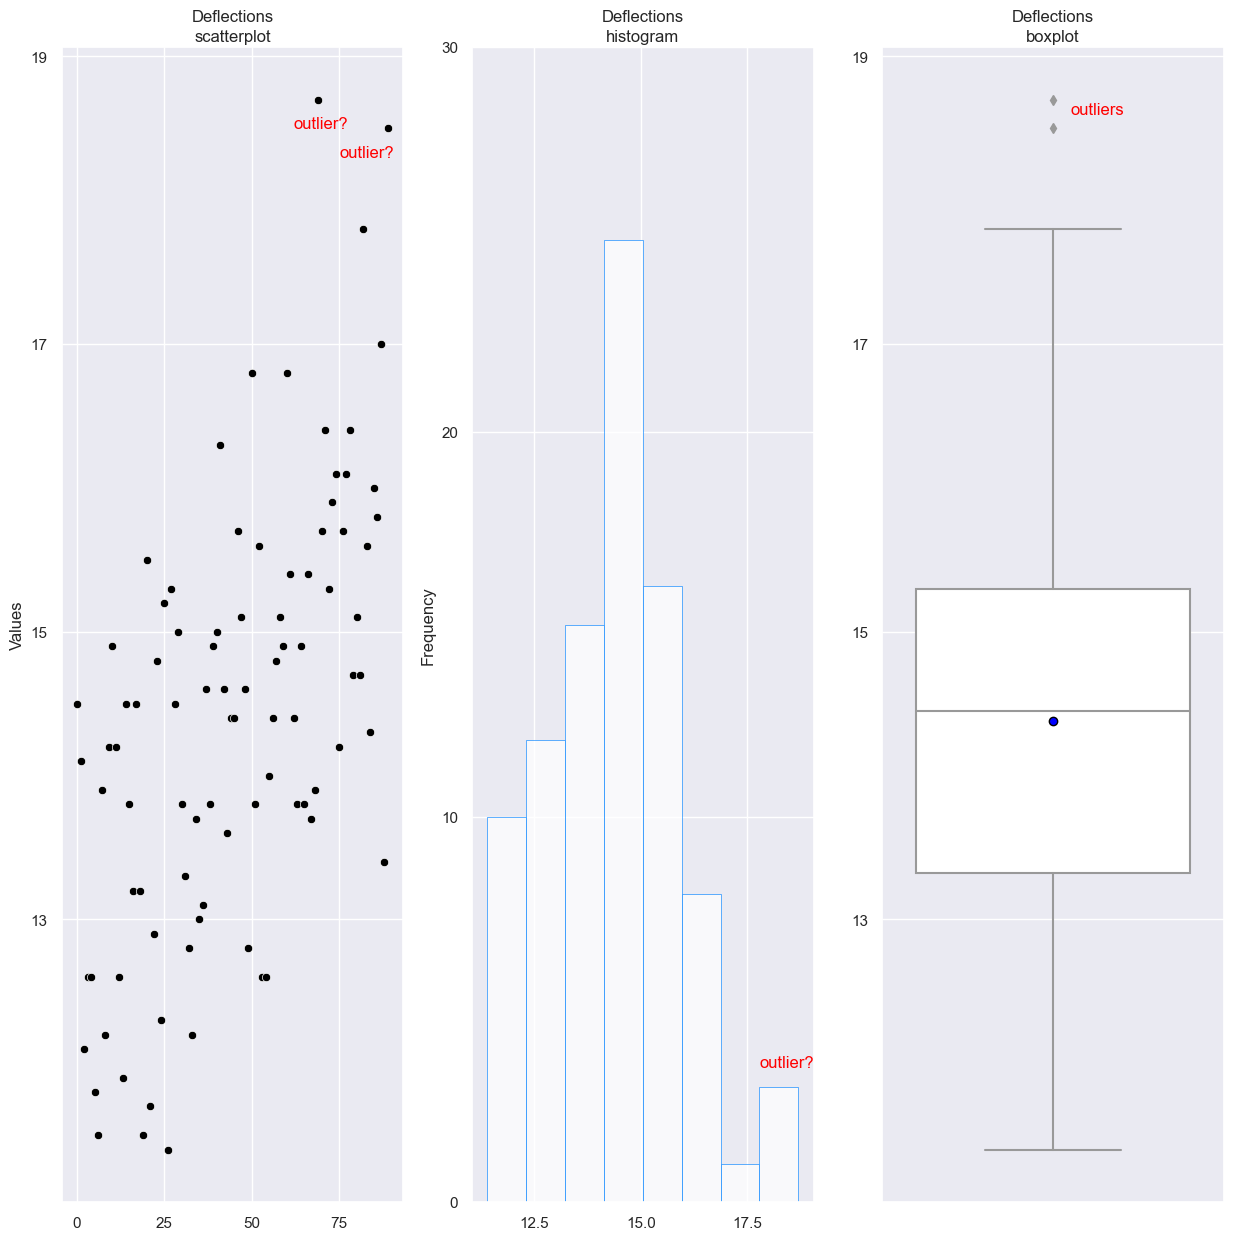

In [18]:
# #Set fig size
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize = (15, 15))

#plot 1
_= sns.scatterplot(x=x_vals, y=df['deflections'].values, ax=ax1, color='Black')
#configure ticks 
ax1.set_xticks((0, 25, 50, 75))
ax1.set_yticks((13, 15, 17, 19))
# Set label names
ax1.set_ylabel('Values')
ax1.set_title("Deflections")
ax1.xaxis.set_label_position('top')
ax1.set_xlabel('scatterplot')
ax1.text(62, 18.5, "outlier?", color="red")
ax1.text(75, 18.3, "outlier?", color="red")

#plot 2
_= sns.histplot(x=df['deflections'].values, ax=ax2, bins=8, color='white', edgecolor="dodgerblue", linewidth=.5)
# #configure ticks 
ax2.set_xticks((12.5,15.0,17.5))
ax2.set_yticks((0, 10, 20, 30))
# # Set label names
ax2.set_ylabel('Frequency')
ax2.set_title("Deflections")
ax2.xaxis.set_label_position('top')
ax2.set_xlabel('histogram')
ax2.text(17.8, 3.5, "outlier?", color="red")

#plot 3
meanpointprops = dict(marker='o', markeredgecolor='black',
                      markerfacecolor='blue')
_= sns.boxplot(y=df['deflections'].values, ax=ax3, color="White", showmeans=True,  meanprops=meanpointprops)
# #configure ticks 
ax3.set_yticks((13, 15, 17, 19))
# # Set label names
ax3.set_title("Deflections")
ax3.xaxis.set_label_position('top')
ax3.set_xlabel('boxplot')
_ = ax3.text(.05, 18.6, "outliers", color="red")

The variable deflections does, in fact, contain a pair of outliers. 

Our next step is to therefore **winsorize*** the data by reducing the values of the two outliers just enough so that they instead equal the so-called Maximum.

*(Winsorizing or winsorization is the transformation of statistics by limiting extreme values in the statistical data to reduce the effect of possibly spurious outliers)

To winsorize data means to set extreme outliers equal to a specified percentile of the data.

For example, a 90% winsorization sets all observations greater than the 95th percentile equal to the value at the 95th percentile and all observations less than the 5th percentile equal to the value at the 5th percentile.

In effect, to winsorize data means to change extreme values in a dataset to less extreme values.

In [19]:
def winsorize_deflections(x):
    if x > 17.8:
        return 17.8
    else:
        return x
        

In [20]:
df['deflections'] = df['deflections'].apply(lambda x: winsorize_deflections(x))

In [21]:
df['deflections'].max()

17.8

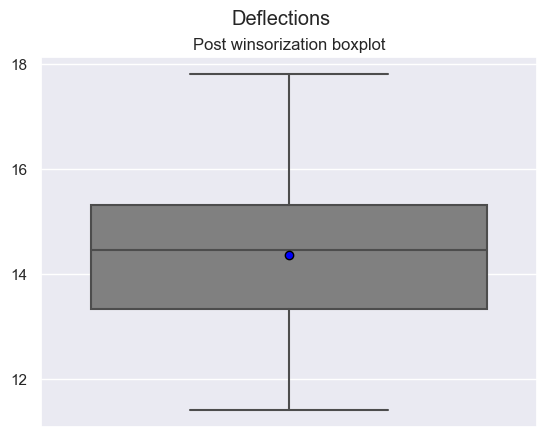

In [22]:
meanpointprops = dict(marker='o', markeredgecolor='black',
                      markerfacecolor='blue')
ax = sns.boxplot(y=df['deflections'].values, color="grey", showmeans=True,  meanprops=meanpointprops)
# #configure ticks 
ax.set_yticks((12, 14, 16, 18))
# # Set label names
ax.set_title("Post winsorization boxplot")
_ = plt.suptitle("Deflections")

##### Summary 

- We then chose boxplots over scatterplots and histograms, because identifying outliers in boxplots is less subjective than doing so with other visualizations. 
- Furthermore, boxplots are better visuals than the alternatives when it then comes to deciding how much to decrease or increase the values of outliers to effectively eliminate them as outliers.
- Rather than removing outliers from our data, we instead landed on winsorization, due to the hustle data set being only 90 rows long.

In [23]:
df.columns

Index(['team', 'season', 'team_season', 'screen_assists', 'screen_assists_pts',
       'deflections', 'loose_balls', 'charges', 'contested_2pt',
       'contested_3pt', 'contested_shots', 'wins'],
      dtype='object')

### Identifying other outliers

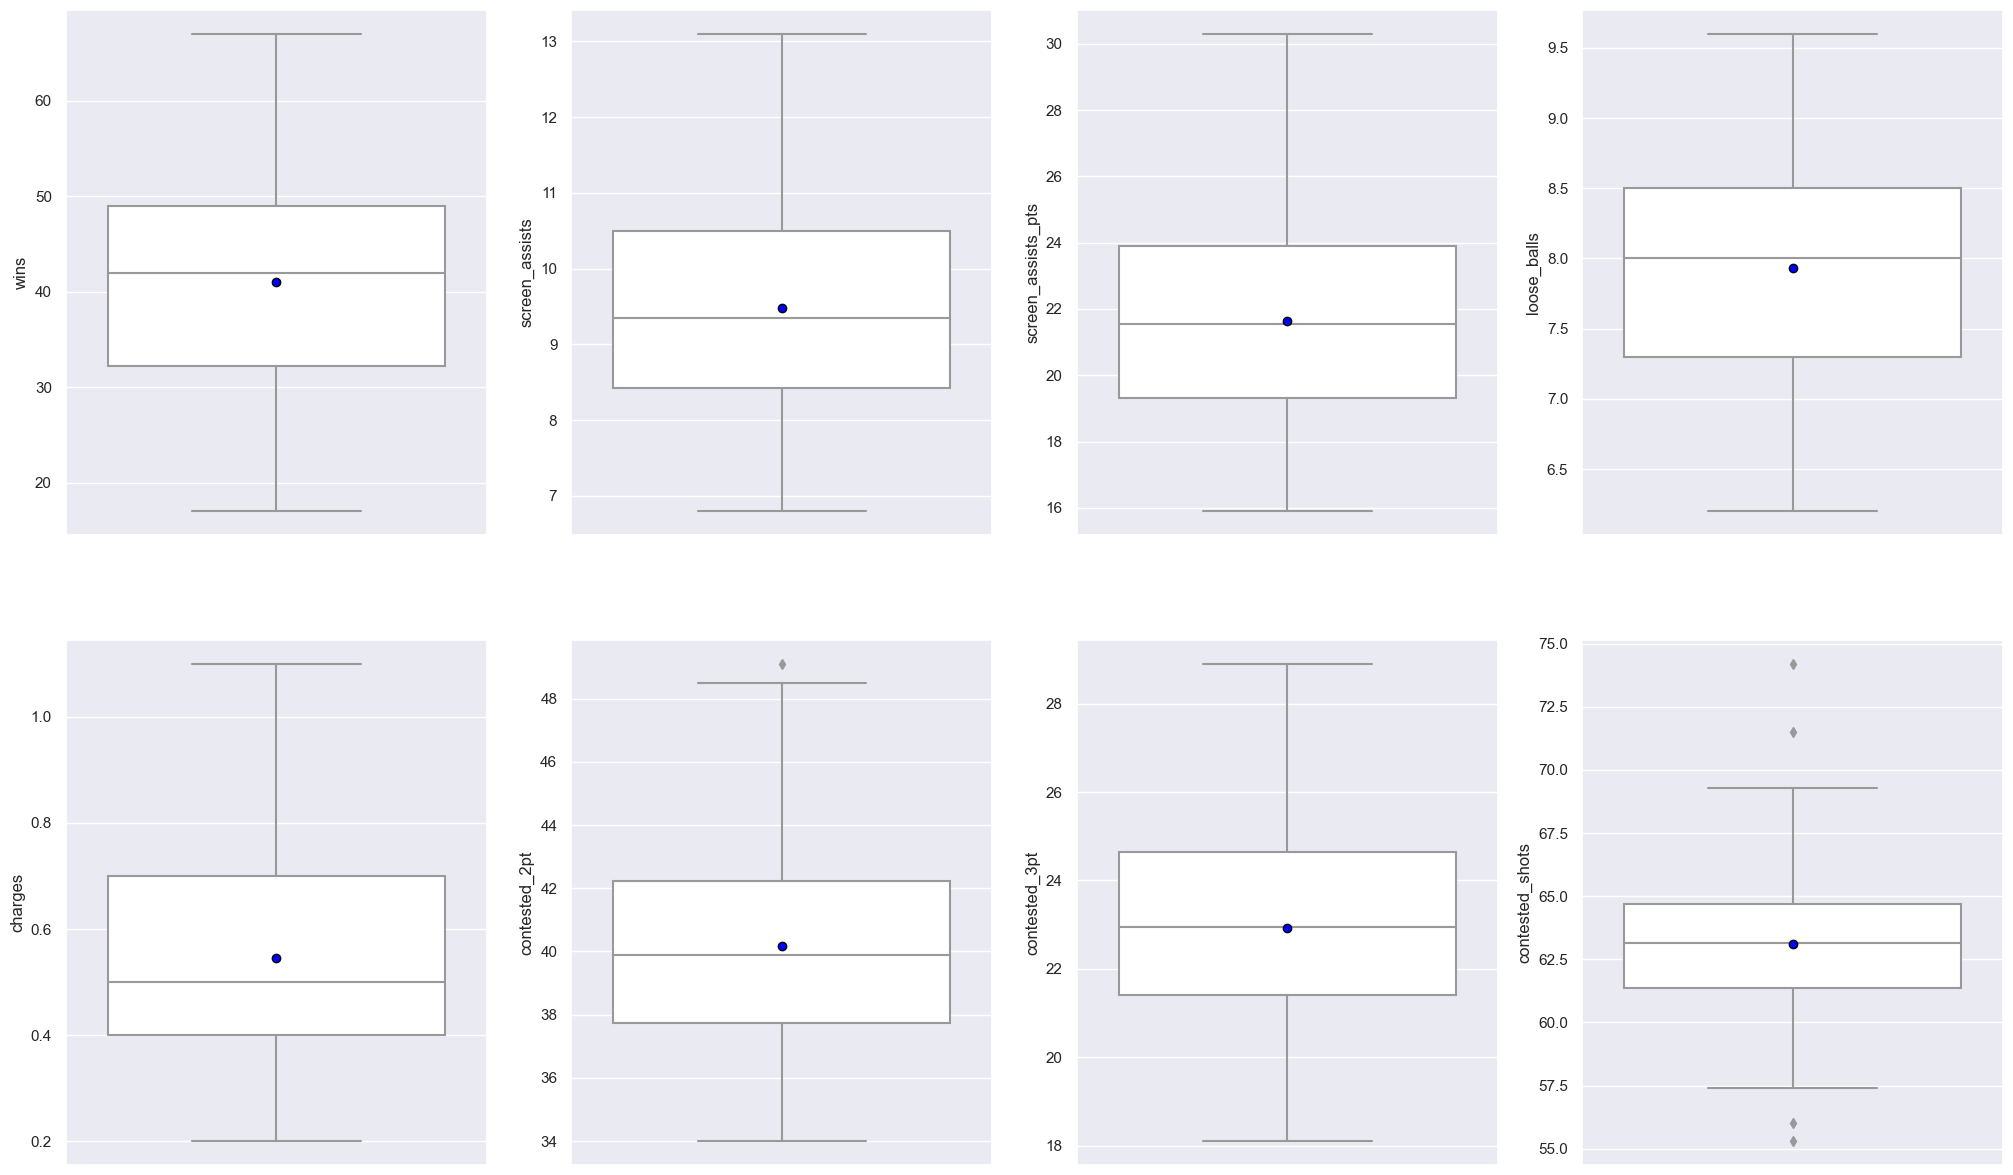

In [24]:
# #Set fig size
f, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(25, 15))

meanpointprops = dict(marker='o', markeredgecolor='black',
                      markerfacecolor='blue')
#plt 1 
ax = sns.boxplot(y=df['wins'], color="white", ax=ax1, showmeans=True,  meanprops=meanpointprops)

#plt 2 
ax = sns.boxplot(y=df['screen_assists'], color="white", ax=ax2, showmeans=True,  meanprops=meanpointprops)

#plt 3 
ax = sns.boxplot(y=df['screen_assists_pts'], color="white", ax=ax3, showmeans=True,  meanprops=meanpointprops)

#plt 4 
ax = sns.boxplot(y=df['loose_balls'], color="white", ax=ax4,showmeans=True,  meanprops=meanpointprops)

#plt 5 
ax = sns.boxplot(y=df['charges'], color="white", ax=ax5,showmeans=True,  meanprops=meanpointprops)

#plt 6 
ax = sns.boxplot(y=df['contested_2pt'], color="white", ax=ax6,showmeans=True,  meanprops=meanpointprops)

#plt 7 
ax = sns.boxplot(y=df['contested_3pt'], color="white", ax=ax7, showmeans=True,  meanprops=meanpointprops)

#plt 8 
ax = sns.boxplot(y=df['contested_shots'], color="white", ax=ax8, showmeans=True,  meanprops=meanpointprops)

Other than the variable deflections, just two other variables in the hustle data set contain outliers: contested_2pt and contested_shots. 

- The variable contested_2pt has a single outlier beyond the Maximum 
- The variable contested_shots has a pair of outliers above the Maximum and two more outliers below the Minimum.

In [25]:
def winsorize(x, val, op):
    if op == ">":
        if x > val:
            return val
        return x
    else:
        if x < val:
            return val
        return x

In [26]:
df['contested_2pt'] = df['contested_2pt'].apply(lambda x: winsorize(x, 48.5, ">"))
df['contested_shots'] = df['contested_shots'].apply(lambda x: winsorize(x, 69.3, ">"))
df['contested_shots'] = df['contested_shots'].apply(lambda x: winsorize(x, 57.4, "<"))

Linear regressions also expect the dependent and independent variables to be normally distributed in order to get best results (which is why non-normal variables are oftentimes transformed to make them normal). 

Now that our dataframe is outlier-free by no means guarantees that our variables now assume normal, or Gaussian, distributions. 

Next, we’ll visualize the distribution of every variable with a series of density plots and complement our ongoing visual approach with a statistical test against each variable to determine whether or not each is normally distributed.

### Checking for normality: prototype

create a series of density plots as a means of visualizing each variable’s frequency distribution, or shape.

Tthe shapiro.test() function will be called just before creating each density plot in order to run a Shapiro-Wilk test and determine whether or not each variable, regardless of how normal or not so normal their distributions may appear, measures up. The Shapiro-Wilk test is just one of several normality tests, though no doubt the most common. Another, fairly common, normality test is the Kolmogorov-Smirnov test.

The null hypothesis for a Shapiro-Wilk test is that the data are normally distributed. So, if the p-value–defined as the probability that an observed difference could have otherwise occurred by random chance–is less than or equal to 0.05 we reject the null hypothesis and conclude the data is non-normal; alternatively, when the p-value is greater than 0.05 we will instead conclude that the null hypothesis should not be rejected.

Primer to hypothesis testing and p-values

- Hypothesis testing, or statistical inference, is all about testing an assumption and drawing a conclusion from one or more data series; hypothesis testing essentially evaluates how unusual, or not so unusual, the results are and whether or not they are too extreme, or improbable, to be the outcome of chance.

- Our starting assumption should always be what’s known as the null hypothesis, designated as H0. Which is to suggest that nothing statistically significant or out of the ordinary exists in one variable or between two data series. We therefore require extraordinary evidence to reject the null hypothesis and to instead accept the alternative hypothesis, designated as H1.

- That evidence is the p-value and specifically the generally-accepted 5% threshold for significance. While 5% might be somewhat arbitrary, we can otherwise agree it’s a very low number, and therefore we’re setting a high bar to overturn, or reject, a null hypothesis

In [27]:
def_stats = stats.shapiro(df.deflections)
def_stats.pvalue

0.4235016107559204

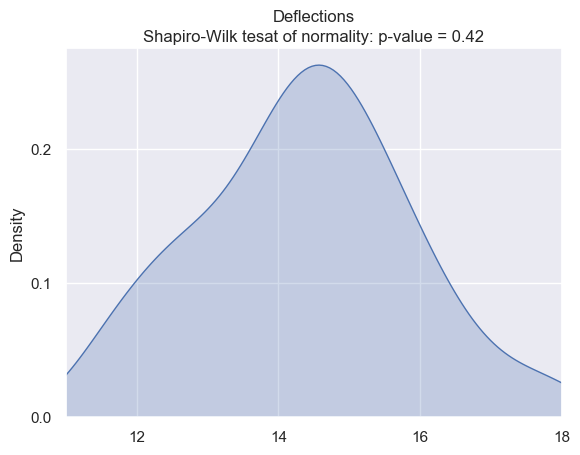

In [28]:
ax = sns.kdeplot(df.deflections, fill=True)
ax.set_xticks((12, 14, 16, 18))
ax.set_yticks((0.0, 0.1, 0.2))
ax.set_xlim((11, 18))

ax.set_title("Deflections")
ax.set_xlabel("Shapiro-Wilk tesat of normality: p-value = 0.42")
ax.xaxis.set_label_position('top')

The variable deflections appears to have a normal distribution and, based on the Shapiro-Wilk test results, where the p-value is significantly above the 0.05 threshold for significance, is normally distributed.

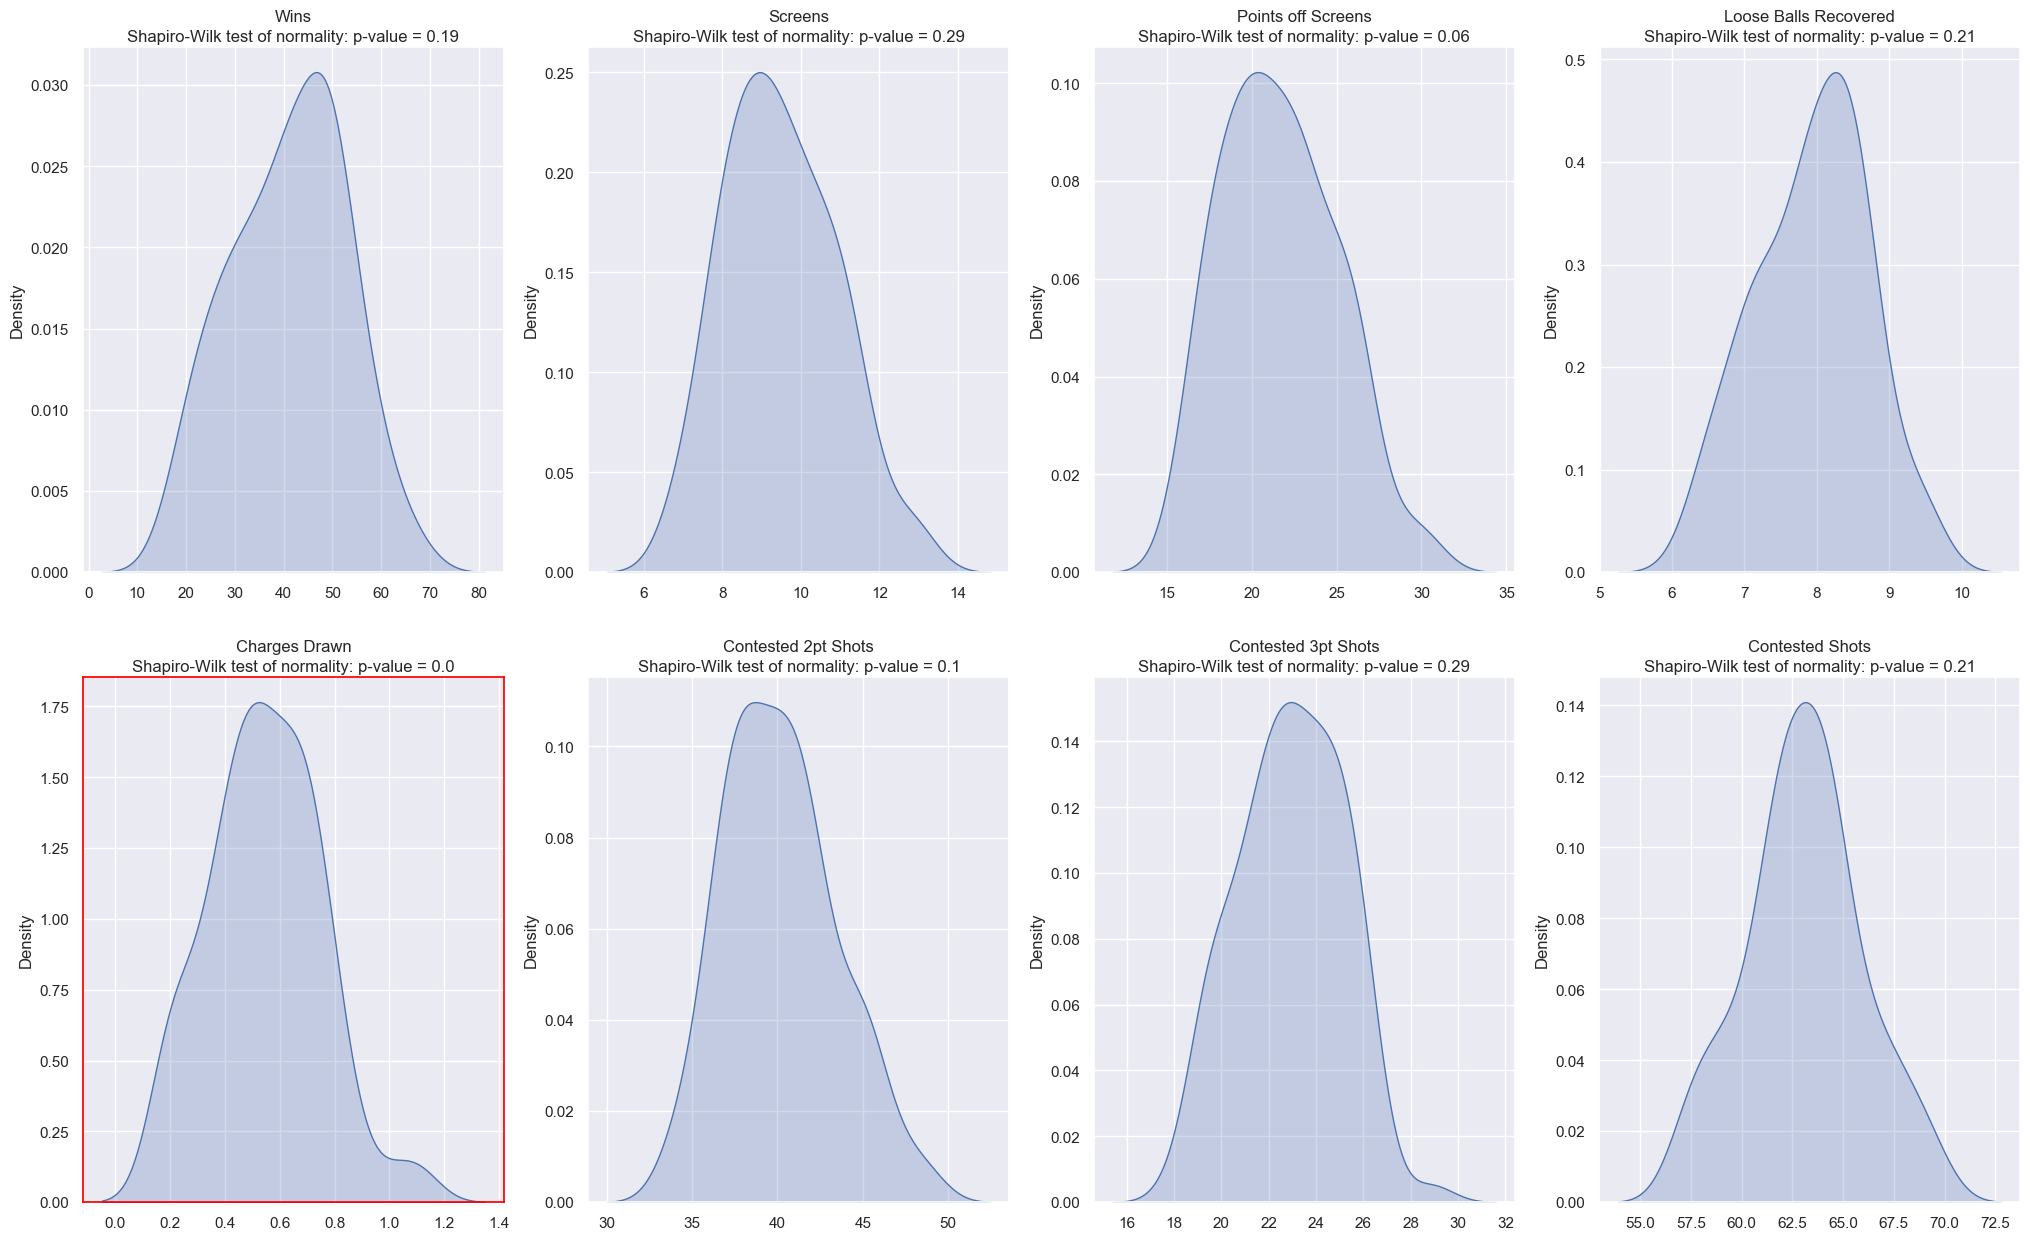

In [29]:
# #Set fig size
f =  plt.figure(figsize=(25, 15))
# f, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(25, 15))

#plt 1 
ax1 = f.add_subplot(241)
ax = sns.kdeplot(df['wins'], fill=True, ax=ax1)
ax.set_title("Wins")
ax.set_xlabel("Shapiro-Wilk test of normality: p-value = {}".format(round(stats.shapiro(df.wins).pvalue, 2)))
ax.xaxis.set_label_position('top')

#plt 2 
ax2 = f.add_subplot(242)
ax = sns.kdeplot(df['screen_assists'], fill=True, ax=ax2)
ax.set_title("Screens")
ax.set_xlabel("Shapiro-Wilk test of normality: p-value = {}".format(round(stats.shapiro(df.screen_assists).pvalue, 2)))
ax.xaxis.set_label_position('top')

#plt 3 
ax3 = f.add_subplot(243)
ax = sns.kdeplot(df['screen_assists_pts'], fill=True, ax=ax3)
ax.set_title("Points off Screens")
ax.set_xlabel("Shapiro-Wilk test of normality: p-value = {}".format(round(stats.shapiro(df.screen_assists_pts).pvalue, 2)))
ax.xaxis.set_label_position('top')

#plt 4
ax4 = f.add_subplot(244)
ax = sns.kdeplot(df['loose_balls'], fill=True, ax=ax4)
ax.set_title("Loose Balls Recovered")
ax.set_xlabel("Shapiro-Wilk test of normality: p-value = {}".format(round(stats.shapiro(df.loose_balls).pvalue, 2)))
ax.xaxis.set_label_position('top')

#plt 5 
with sns.axes_style(rc={'axes.edgecolor': 'red', 'patch.edgecolor': 'red', 'patch.force_edgecolor': False}):
    ax5 = f.add_subplot(245)
    ax = sns.kdeplot(df['charges'], fill=True, ax=ax5)
    ax.set_title("Charges Drawn")
    ax.set_xlabel("Shapiro-Wilk test of normality: p-value = {}".format(round(stats.shapiro(df.charges).pvalue, 2)))
    ax.xaxis.set_label_position('top')

#plt 6 
ax6 = f.add_subplot(246)
ax = sns.kdeplot(df['contested_2pt'], fill=True, ax=ax6)
ax.set_title("Contested 2pt Shots")
ax.set_xlabel("Shapiro-Wilk test of normality: p-value = {}".format(round(stats.shapiro(df.contested_2pt).pvalue, 2)))
ax.xaxis.set_label_position('top')

#plt 7 
ax7 = f.add_subplot(247)
ax = sns.kdeplot(df['contested_3pt'], fill=True, ax=ax7)
ax.set_title("Contested 3pt Shots")
ax.set_xlabel("Shapiro-Wilk test of normality: p-value = {}".format(round(stats.shapiro(df.contested_3pt).pvalue, 2)))
ax.xaxis.set_label_position('top')

#plt 8 
ax8 = f.add_subplot(248)
ax = sns.kdeplot(df['contested_shots'], fill=True, ax=ax8)
ax.set_title("Contested Shots")
ax.set_xlabel("Shapiro-Wilk test of normality: p-value = {}".format(round(stats.shapiro(df.contested_shots).pvalue, 2)))
ax.xaxis.set_label_position('top')


Turns out only the variable charges has a non-normal distribution, based on the Shapiro-Wilk tests and drawing a line in the sand where the p-value is above or below the 0.05 threshold for significance. 

The variables screen_assists_pts and even the variable contested_2pt have Shapiro-Wilk p-values barely above 0.05, thereby indicating their respective distributions are almost non-normal. But again, we’re applying a p-value of 0.05 as a hard cutoff; therefore, we will not consider the variable charges in our linear modeling.

In [30]:
df.drop(columns=['charges'], inplace=True)

### Visualizing and testing correlations: prototype

- we first identified outliers in our data and then subsequently capped those same values so that they equal the Maximum or Minimum.

- Second, we tested our variables for normality to determine which of these to carry forward and which to discard from any further analysis and testing.

- Finally, we’ll compute the correlation coefficients between the variable wins and the remaining variables and visualize the same with a correlation matrix.

Our purpose here is to identify which variables might be best fits, or not fits at all, as predictors in our linear regression model. 

This is an especially relevant exercise when working with wide data sets–it makes much more sense to further examine the data and identify high-potential predictors as opposed to including every independent variable in a model regardless of whether or not any value is being added.

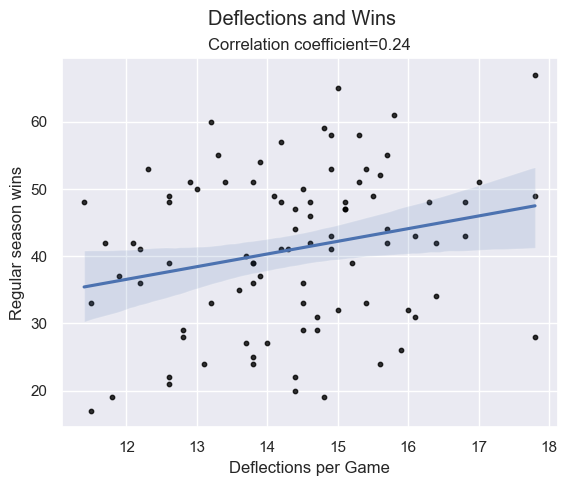

In [31]:
ax = sns.regplot(x= df.deflections, y=df.wins, scatter_kws={"color": "black", "s": 10})
# Set label names
ax.set_xlabel('Deflections per Game')
ax.set_ylabel('Regular season wins')
ax.set_title("Correlation coefficient={}".format(round(df['deflections'].corr(df['wins']), 2)))
_ = plt.suptitle("Deflections and Wins")

There is positive correlation at .24 but it is rather unremarkable 

### Visualizing and testing other correlations


In [32]:
from scipy.stats import pearsonr
def corrfunc(x, y, hue=None, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'Corr: {r:.3f}', xy=(.1, .9), xycoords=ax.transAxes, fontweight = 'bold')

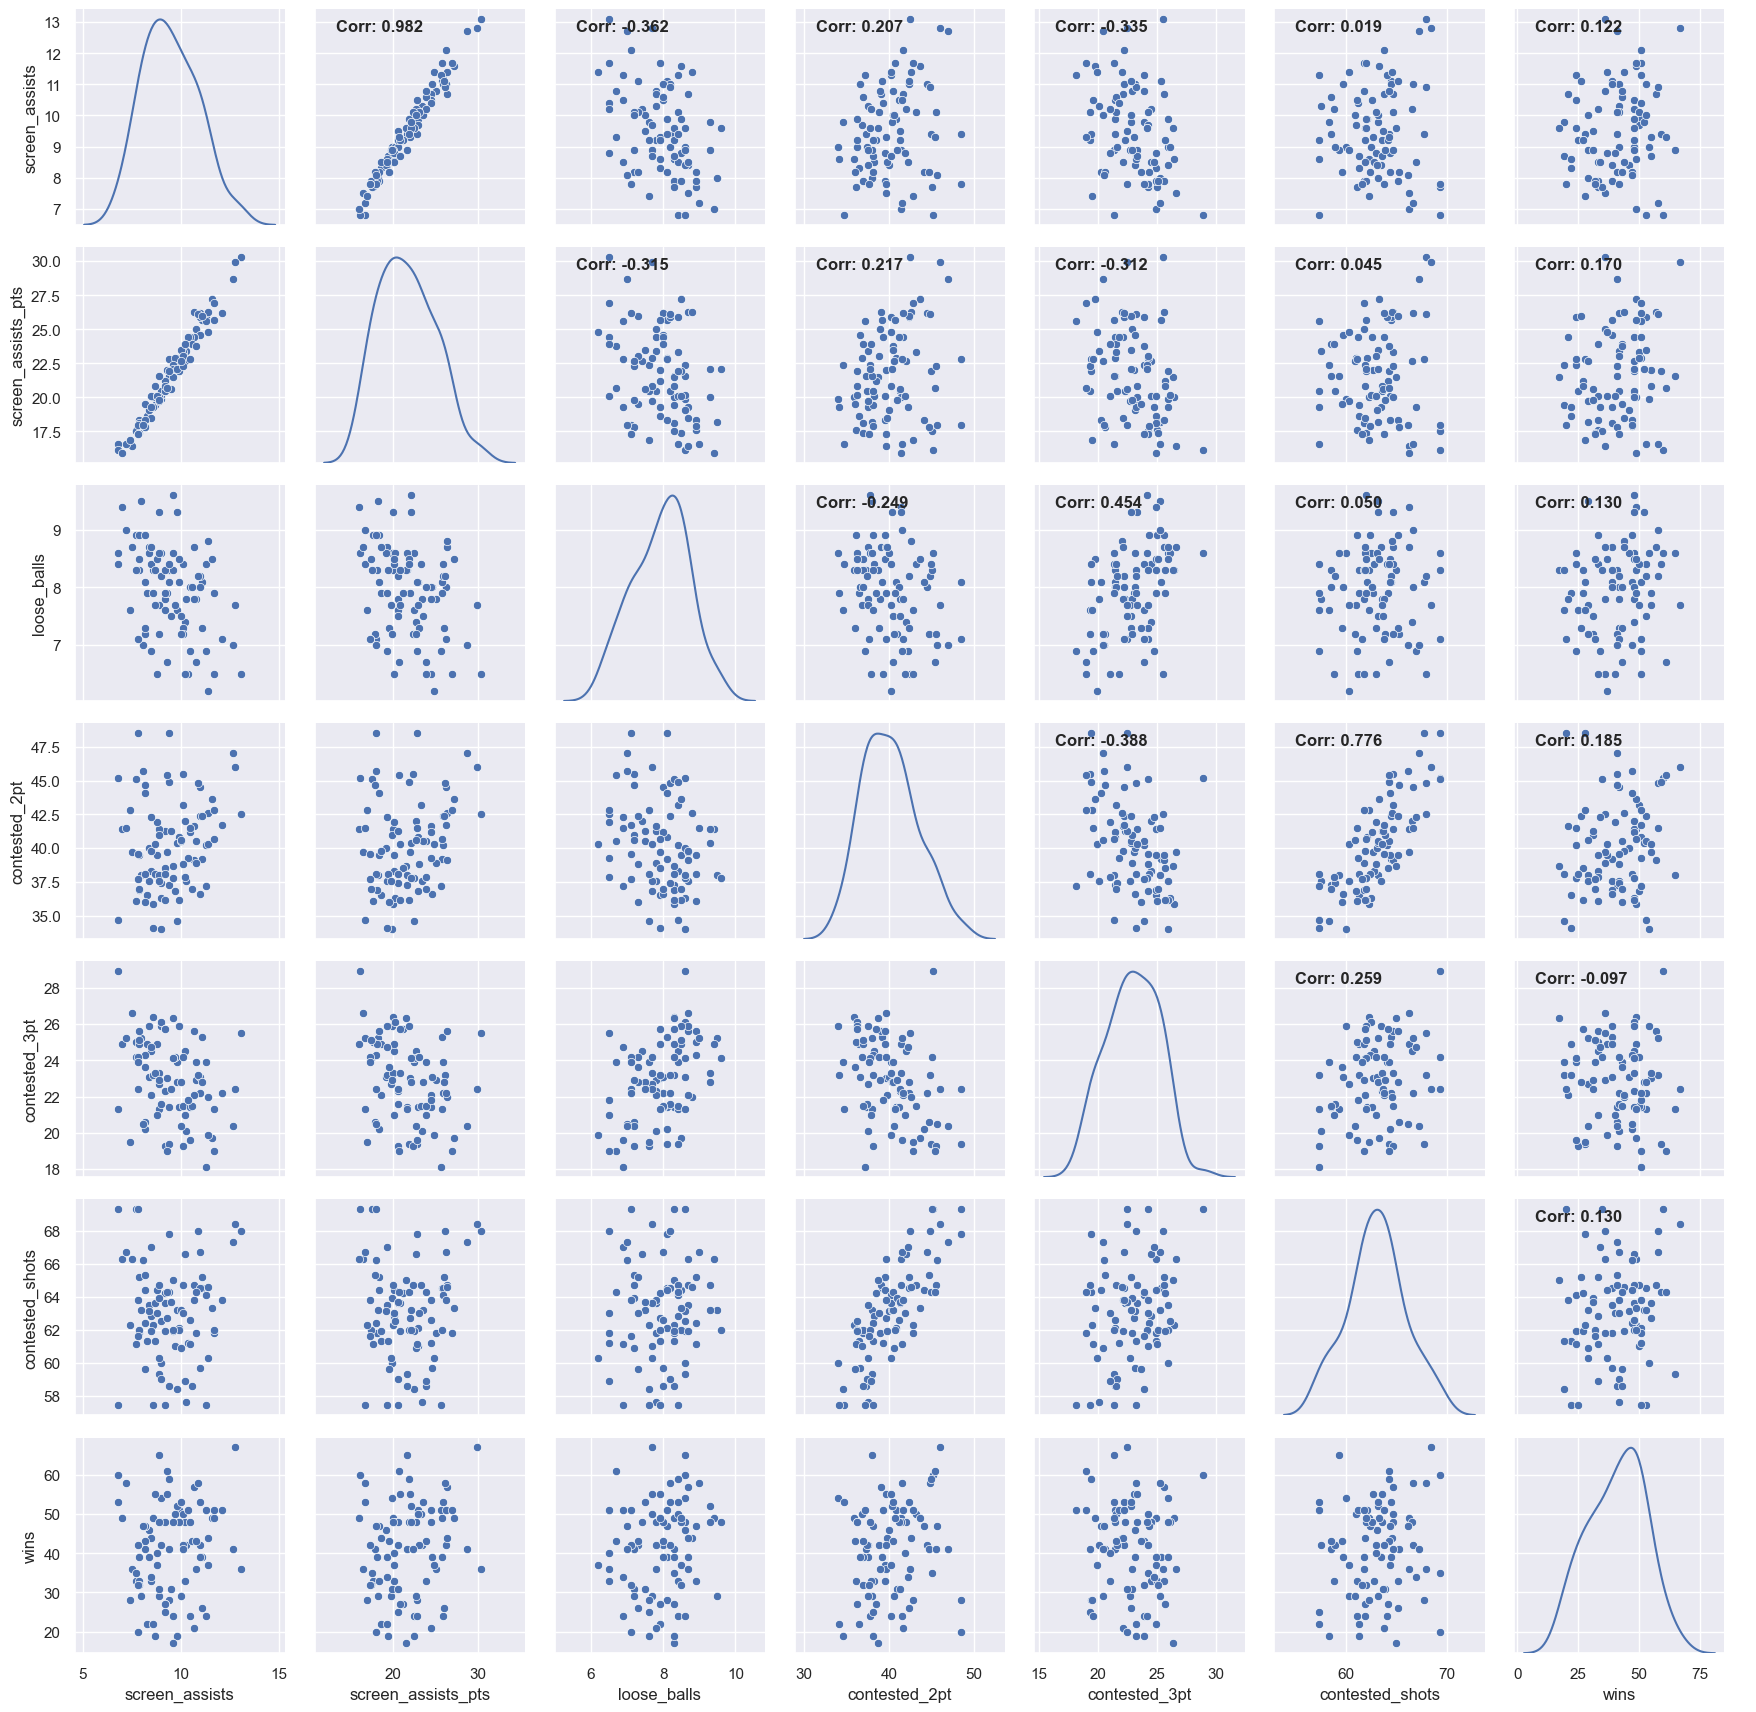

In [33]:
g = sns.PairGrid(df[['screen_assists', 'screen_assists_pts', 'loose_balls', 'contested_2pt', 'contested_3pt','contested_shots', 'wins']], diag_sharey=False)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.scatterplot)
g.map_upper(corrfunc)
g.add_legend()

In [34]:
df[['screen_assists', 'screen_assists_pts', 'loose_balls', 'contested_2pt', 'contested_3pt','contested_shots', 'wins']].corr()

,screen_assists,screen_assists_pts,loose_balls,contested_2pt,contested_3pt,contested_shots,wins
screen_assists,1.00,0.98,-0.36,0.21,-0.33,0.02,0.12
screen_assists_pts,0.98,1.00,-0.32,0.22,-0.31,0.04,0.17
loose_balls,-0.36,-0.32,1.00,-0.25,0.45,0.05,0.13
contested_2pt,0.21,0.22,-0.25,1.00,-0.39,0.78,0.19
contested_3pt,-0.33,-0.31,0.45,-0.39,1.00,0.26,-0.10
contested_shots,0.02,0.04,0.05,0.78,0.26,1.00,0.13
wins,0.12,0.17,0.13,0.19,-0.10,0.13,1.00


None of the remaining hustle variables has a strong correlation, one way or the other, with wins; 

in fact, none have correlation coefficients with wins equal to or as meaningful as the correlation coefficient between deflections and wins.

### Summary 

That concludes all the linear regression pre-work. We’ve identified and then adjusted outlying values; we’ve tested for normality and then determined which subset of hustle variables to move forward with; and we’ve tested the correlations between potential predictors and the variable wins and determined that **deflections**, **contested_2pt**, and **screen_assists_pts** might have more influence on wins than other variables, due to their correlation coefficients with wins being the furthest from perfectly neutral

### Linear regression

Our multiple regression exercise starts by subsetting 75% of the hustle observations into a data set called train and the remaining 25% into test; we’ll develop our linear models against train and then predict on test. If instead we were to develop and predict on 100% of the records we would run the risk of overfitting our models; that is, they would basically memorize the data and not necessarily respond well to new data

In [35]:
test_df = df.iloc[::4, :]
train_df = df.loc[~df.index.isin(test_df.index.values)]

In [36]:
test_df.shape, train_df.shape

((23, 11), (67, 11))

In [116]:
x = sm.add_constant(train_df[["deflections", "contested_2pt", "screen_assists_pts", "loose_balls", "contested_shots"]]) # adding a constant
# display(x)
model = sm.OLS(train_df[['wins']], x).fit()
predictions = model.predict(x) 
 
print_model = model.summary()
print(print_model)
model_regress_results = pd.read_html(print_model.tables[0].as_html(header=1,index_col=0))[0]
results_as_html = print_model.tables[1].as_html()
lm_df = pd.read_html(results_as_html, header=0, index_col=0)[0]

                            OLS Regression Results                            
Dep. Variable:                   wins   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     3.091
Date:                Fri, 21 Jul 2023   Prob (F-statistic):             0.0150
Time:                        11:39:14   Log-Likelihood:                -251.89
No. Observations:                  67   AIC:                             515.8
Df Residuals:                      61   BIC:                             529.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -62.9091     38

In [38]:
lm_df

,coef,std err,t,P>|t|,[0.025,0.975]
const,-62.91,38.61,-1.63,0.11,-140.11,14.29
deflections,2.23,0.88,2.54,0.01,0.47,4.00
contested_2pt,0.52,0.76,0.69,0.49,-1.00,2.05
screen_assists_pts,1.04,0.44,2.35,0.02,0.16,1.92
loose_balls,5.38,2.19,2.46,0.02,1.00,9.77
contested_shots,-0.24,0.79,-0.30,0.76,-1.82,1.34


Linear equation 

- y is the predicted value of the dependent variable wins.
- B0 is the y-intercept, or constant term; it represents the value at which the fitted regression line crosses the y-axis.
- B1X1 is the regression coefficient of the first fit1 predictor, screen_assists_pts, where B1 equals 1.04 and X1 is the average number of points scored per game off set screens.
- B2X2 is the regression coefficient of the second predictor, deflections, where B2 equals 2.23 and X2 is the average number of deflections per game.
- B3X3 is the regression coefficient of loose_balls, or 5.38 times the average number of loose balls recovered per game.
- B4X4 is the regression coefficient of contested_2pt, or 0.53 times the average number of two-point shot attempts contested per game.
- B5X5 is the regression coefficient of contested_shots, or -0.24 multiplied by the average number of total shot attempts contested per game.

`y = B0 + B1X1 + B2X2 + B3X3 + B4X4 + B5X5`

Using the linear equation above check dthe MIA 2017 record to predict total wins 

In [40]:
df.loc[df.team_season == 'MIA 17'][['screen_assists', 'screen_assists_pts', 'loose_balls', 'contested_2pt', 'contested_3pt','contested_shots', 'wins']]

,screen_assists,screen_assists_pts,loose_balls,contested_2pt,contested_3pt,contested_shots,wins
75,10.10,22.30,7.20,45.50,19.30,64.70,41


With the above data, lets plug in the values into the linear equation

In [47]:
wins = -62.91 + (1.04 * 22.3) + (2.23 * 14.2) + (5.38 * 7.2) + (0.52 * 45.5) - (0.24 * 64.7)
round(wins)

39

Total of 39 predicted wins (actual is 41)

Let's plug 8.2 loose balls per game rather than the 7.2 they actual obtained

In [48]:
wins = -62.91 + (1.04 * 22.3) + (2.23 * 14.2) + (5.38 * 8.2) + (0.52 * 45.5) - (0.24 * 64.7)
round(wins)

44

for every unit increase (or decrease) in the variable loose_balls, the predicted value for wins will increase (or decrease) by 5.38. By the same token, if the Heat had managed to deflect one more pass per game, fit1 would then predict 2.23 more wins.

Only the variables screen_assists_pts, deflections, and loose_balls have p-values below the generally-accepted 0.05 threshold for significance, whereas the variables contest_2pt and contested_shots have p-values significantly above the 5% threshold. Therefore, our first multiple linear regression has revealed that only *some* hustle statistics have a significant influence on regular season win counts

In [57]:
pred = model.get_prediction(x)
pred_df = pred.summary_frame()

In [59]:
pred_df.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
1,37.84,2.64,32.57,43.12,15.44,60.24
2,41.64,3.59,34.46,48.82,18.72,64.56
3,40.53,2.96,34.61,46.44,17.97,63.09
5,31.68,3.69,24.30,39.07,8.69,54.67
6,33.81,2.98,27.85,39.78,11.24,56.38


In [68]:
augmented_df = pd.concat([x, train_df['wins'], pred_df,  model.resid], axis=1)

In [69]:
augmented_df.head()

,const,deflections,contested_2pt,screen_assists_pts,loose_balls,contested_shots,wins,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,0
1,1.00,14.10,35.90,20.00,8.30,62.30,49,37.84,2.64,32.57,43.12,15.44,60.24,11.16
2,1.00,12.10,44.50,26.20,8.00,66.70,42,41.64,3.59,34.46,48.82,18.72,64.56,0.36
3,1.00,12.60,39.20,25.70,8.10,64.50,39,40.53,2.96,34.61,46.44,17.97,63.09,-1.53
5,1.00,11.80,34.60,22.40,7.60,58.40,19,31.68,3.69,24.30,39.07,8.69,54.67,-12.68
6,1.00,11.50,38.30,20.10,8.40,62.80,33,33.81,2.98,27.85,39.78,11.24,56.38,-0.81


create a new variable, wins_dif, which is the absolute difference between the agumented variables wins and mean from our model (listed as .fitted in the book) 

we then call the mean() to compute the average difference between actual wins and fitted wins from our model.



In [ ]:
augmented_df['wins_dif'] = augmented_df.apply(lambda x: abs(x['wins'] - x['mean']), axis=1)

On average, our linear equation returns regular season win counts that are 8.27 wins above or below actual regular season win counts.

In [80]:
augmented_df['wins_dif'].mean()

8.274886605435379

Unlike the code in the book for R we don't need to rely on the glance function since we got the same results from our model output above

In [103]:
model_regress_results

,0,1,2,3
0,Dep. Variable:,wins,R-squared:,0.20
1,Model:,OLS,Adj. R-squared:,0.14
2,Method:,Least Squares,F-statistic:,3.09
3,Date:,"Fri, 21 Jul 2023",Prob (F-statistic):,0.01
4,Time:,11:11:44,Log-Likelihood:,-251.89
5,No. Observations:,67,AIC:,515.80
6,Df Residuals:,61,BIC:,529.00
7,Df Model:,5,NaN,NaN
8,Covariance Type:,nonrobust,NaN,NaN


Because R2 equals 0.20, the model predictors, regardless of their respective p-values, collectively explain approximately 20% of the variance in wins.

Where a response variable is regressed against multiple predictors, as in our model, R2 will **always increase** as more predictors are added to the model, regardless of how significant, or not so significant, they are; that’s why the Adjusted R2 statistic is a more appropriate measure. The more statistically-insignificant predictors a model contains the more R2 and Adjusted R2 will diverge from one another. 

Since our model contains a pair of predictors with p-values above the 0.05 threshold for significance–noise basically–the Adjusted R2 statistic equals just 0.14, thereby suggesting that the model best explains about 14%, rather than 20%, of the variance in wins.

### Checking for multicollinearity

multicollinearity is a situation in which two or more independent variables are highly correlated in a regression model

The VIF function in R measures how much the variance of an estimated regression coefficient increases when your predictors are correlated

In [127]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(predictors):
    # predictors - a constant term for the intercept
     
    vif_data = pd.DataFrame()
    vif_data["Variable"] = predictors.columns
    vif_data["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]

    return vif_data


In [128]:
vif_result = calculate_vif(x)
vif_result

,Variable,VIF
0,const,842.66
1,deflections,1.06
2,contested_2pt,3.05
3,screen_assists_pts,1.16
4,loose_balls,1.31
5,contested_shots,2.64


If the variance inflation factor for any of the model predictors is above 5, we should discard those variables and then fit a reduced model with fewer predictors. But, as we can see, the variance inflation factor for all data predictors is less than 5.

### Running and interpreting model diagnostics

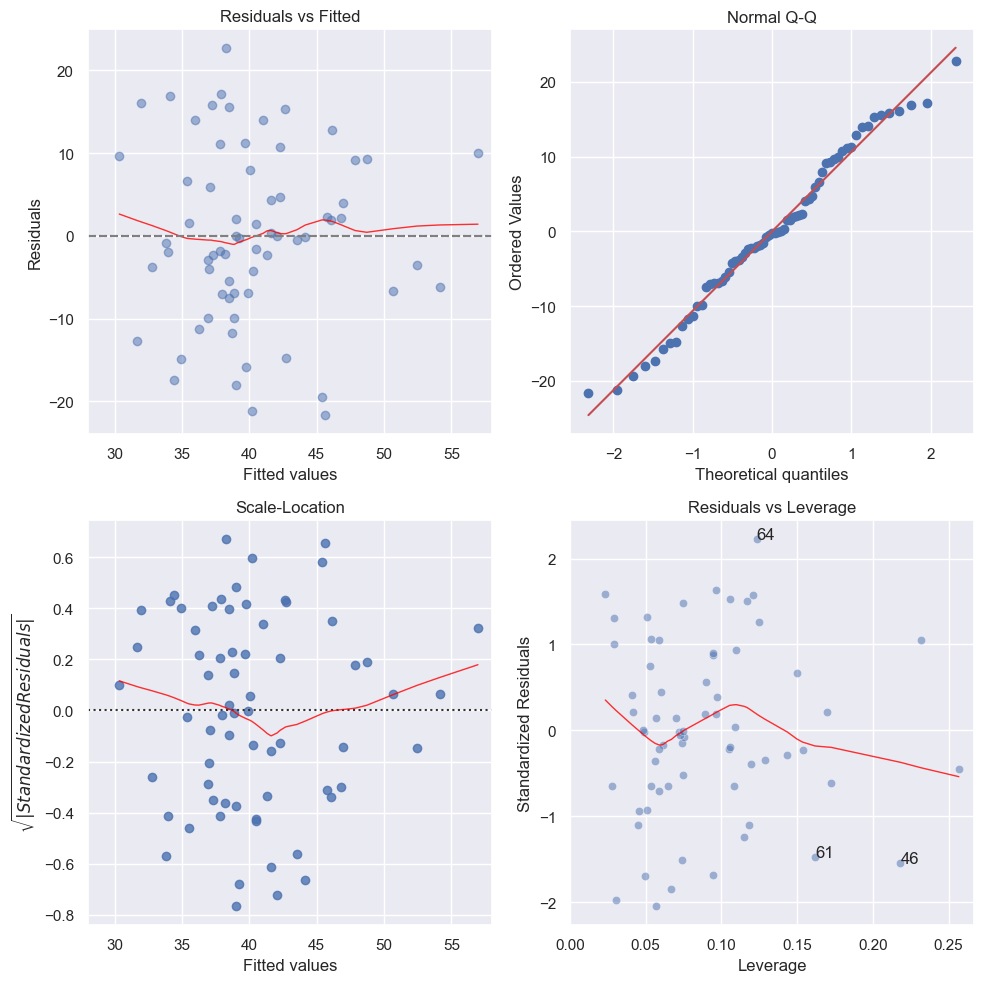

In [366]:
import statsmodels.graphics.regressionplots as smg
import scipy.stats as stats
from statsmodels.graphics.gofplots import ProbPlot

# Calculate Cook's distance
cooks_dist = model.get_influence().cooks_distance[0]
model_leverage = model.get_influence().hat_matrix_diag
model_norm_residuals = model.get_influence().resid_studentized_internal

# Fitted values 
fitted = model.fittedvalues.reset_index()[0]

# Generate diagnostic plots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))


# Plot of the fitted values vs. observed values
sns.residplot(x=fitted, y=resid,
                          ax = axs[0, 0],
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
axs[0, 0].set_xlabel('Fitted values')
axs[0, 0].set_title('Residuals vs Fitted')
axs[0, 0].set_ylabel('Residuals')
axs[0, 0].axhline(0, color='gray', linestyle='--')
axs[0, 0].set_xlim(28, 58)


# Q-Q plot for normality
residuals = model.resid
stats.probplot(residuals, plot=axs[0, 1])
axs[0, 1].set_title('Normal Q-Q')


# Scale-location plot
sqrt_abs_standardized_residuals = np.sqrt(np.abs(model.get_influence().resid_studentized_internal))
sns.residplot(x=fitted, y=sqrt_abs_standardized_residuals, 
              lowess=True,
             ax = axs[1, 0],
             line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
axs[1, 0].set_title('Scale-Location')
axs[1, 0].set_xlabel('Fitted values')
axs[1, 0].set_ylabel('$\sqrt{|Standardized Residuals|}$')
axs[1, 0].set_xlim(28, 58)


# resid vs leverage
axs[1, 1].set_xlim(0, max(model_leverage)+0.01)
axs[1, 1].set_title('Residuals vs Leverage')
axs[1, 1].set_xlabel('Leverage')
axs[1, 1].set_ylabel('Standardized Residuals')
sns.scatterplot(x=model_leverage, y=model_norm_residuals, alpha=0.5, ax = axs[1,1]);
sns.regplot(x=model_leverage, y=model_norm_residuals,
              scatter=False,
              ci=False,
              lowess=True,
               ax = axs[1,1],
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
leverage_top_3 = np.flip(np.argsort(cooks_dist), 0)[:3]
for i in leverage_top_3:
    axs[1, 1].annotate(i, xy=(model_leverage[i], model_norm_residuals[i]))


plt.tight_layout()
plt.show()